Dataset loaded: (303, 14)

=== HEAD ===
 age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  ca  thal  target
  63    1   3       145   233    1        0      150      0      2.3      0   0     1       1
  37    1   2       130   250    0        1      187      0      3.5      0   0     2       1
  41    0   1       130   204    0        0      172      0      1.4      2   0     2       1
  56    1   1       120   236    0        1      178      0      0.8      2   0     2       1
  57    0   0       120   354    0        1      163      1      0.6      2   0     2       1
  57    1   0       140   192    0        1      148      0      0.4      1   0     1       1
  56    0   1       140   294    0        0      153      0      1.3      1   0     2       1
  44    1   1       120   263    0        1      173      0      0.0      2   0     3       1
  52    1   2       172   199    1        1      162      0      0.5      2   0     3       1
  57    1   2       

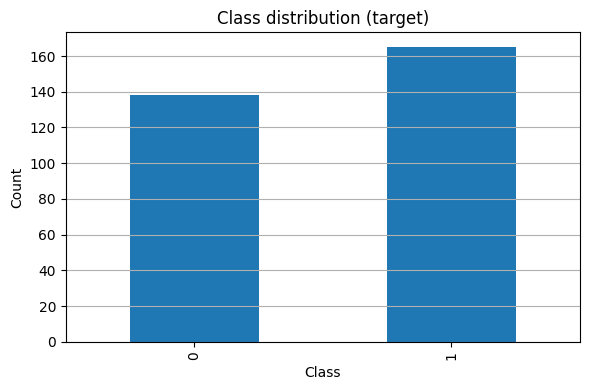

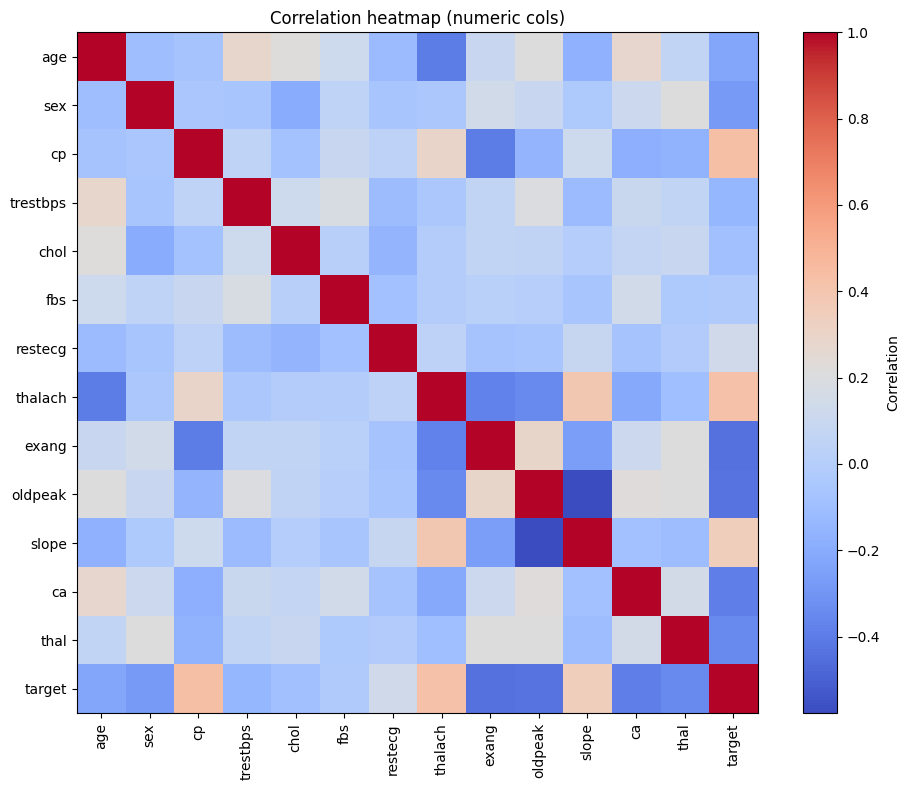

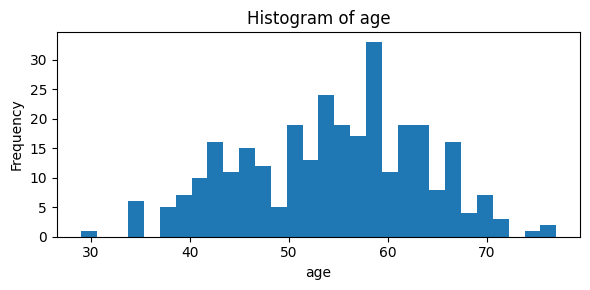

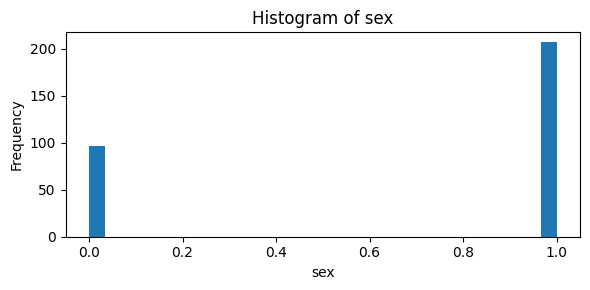

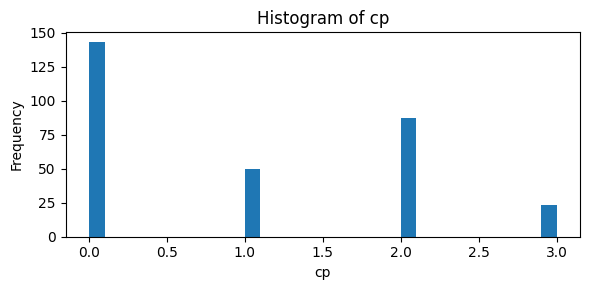

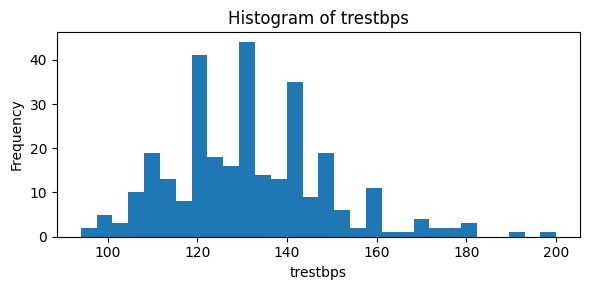

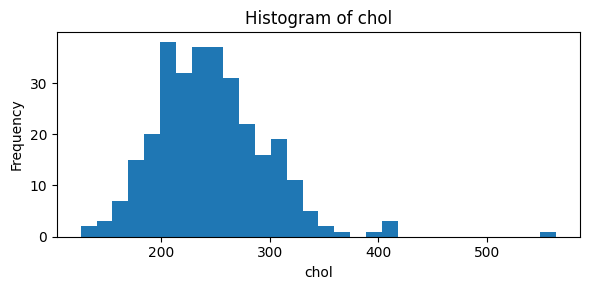

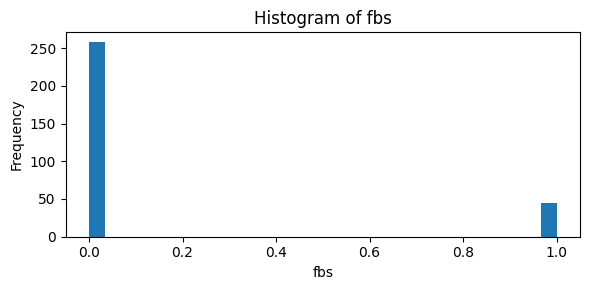

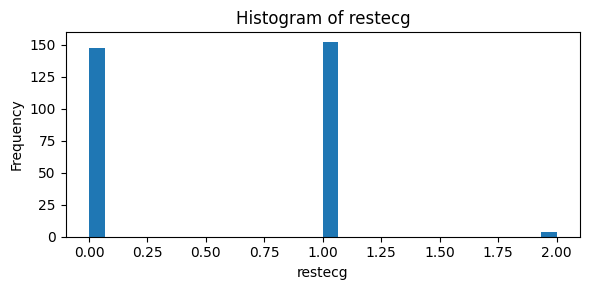

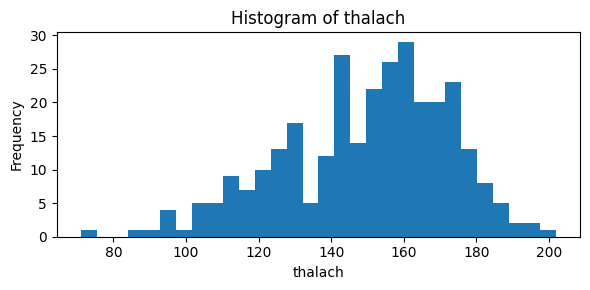


Detected categorical cols (8): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Detected numeric cols (5): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

Remaining missing values (should be 0): 0 target missing: 0

Top features by importance:
cp          0.138561
thalach     0.126287
ca          0.113676
thal        0.110106
oldpeak     0.100177
age         0.087532
trestbps    0.075222
chol        0.074684
exang       0.056959
slope       0.051476
sex         0.033829
restecg     0.021332
fbs         0.010159


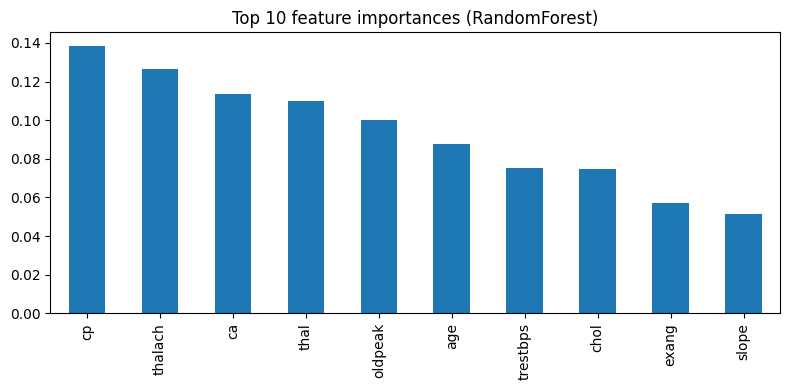


Selected features: ['cp', 'thalach', 'ca', 'thal', 'oldpeak', 'age', 'trestbps', 'chol', 'exang', 'slope', 'sex', 'restecg']

XGBoost available and will be tried.

Training LogisticRegression ...
LogisticRegression -> Accuracy: 0.8033, Precision: 0.7692, Recall: 0.9091, F1: 0.8333, MSE: 0.1967
Confusion Matrix:
 [[19  9]
 [ 3 30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61


Training RandomForest ...
RandomForest -> Accuracy: 0.8197, Precision: 0.7619, Recall: 0.9697, F1: 0.8533, MSE: 0.1803
Confusion Matrix:
 [[18 10]
 [ 1 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76 

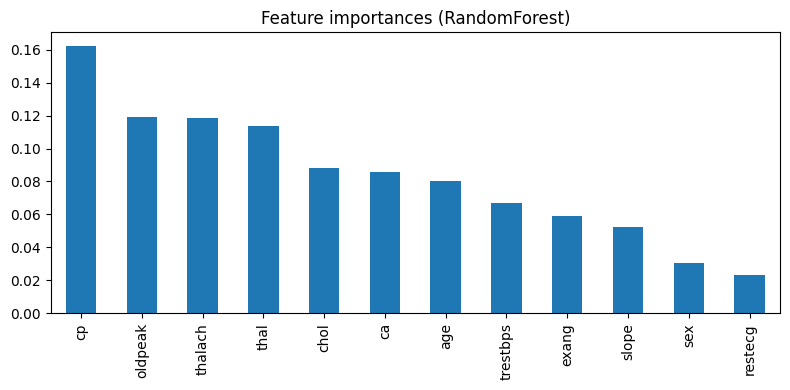


=== Summary of models ===
                    accuracy  precision    recall        f1       mse
LogisticRegression  0.803279   0.769231  0.909091  0.833333  0.196721
RandomForest        0.819672   0.761905  0.969697  0.853333  0.180328
XGBoost             0.803279   0.756098  0.939394  0.837838  0.196721

Best model saved to: /content/best_heart_model.joblib


In [ ]:
# heart_classification_pipeline.py
# Run in Colab / Jupyter. Assumes dataset is at /mnt/data/heart.csv (change DATA_PATH if needed).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, mean_squared_error
)
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# CONFIG / PATH
# -----------------------------
DATA_PATH = "/content/heart.csv"   # change if needed
RANDOM_STATE = 42

# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv(DATA_PATH)
print("Dataset loaded:", df.shape)
print("\n=== HEAD ===")
print(df.head(10).to_string(index=False))

# -----------------------------
# 2) Null / Missing checks
# -----------------------------
print("\n=== Missing values per column ===")
print(df.isnull().sum().sort_values(ascending=False))

# If all zeros, show message
total_missing = df.isnull().sum().sum()
print(f"\nTotal missing values in dataset: {total_missing}")

# -----------------------------
# 3) Quick EDA / Graphs
# -----------------------------
# Try to find target column (common names)
possible_targets = [c for c in df.columns if c.lower() in ['target','heartdisease','heart_disease','heart disease','output','label']]
if len(possible_targets) > 0:
    target_col = possible_targets[0]
else:
    # fallback: last column
    target_col = df.columns[-1]
print("\nUsing target column:", target_col)

# Class distribution plot
plt.figure(figsize=(6,4))
df[target_col].value_counts().sort_index().plot(kind='bar')
plt.title(f'Class distribution ({target_col})')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
corr = num_df.corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation heatmap (numeric cols)')
plt.tight_layout()
plt.show()

# Histograms for numeric columns (first 8)
numeric_cols = num_df.columns.tolist()
for col in numeric_cols[:8]:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col); plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Preprocessing
# -----------------------------
# Separate X, y
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Detect categorical columns (object or low-cardinality)
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# Also treat numeric with very low unique values as categorical (<=6 unique)
for c in X.select_dtypes(include=[np.number]).columns:
    if X[c].nunique() <= 6:
        # but avoid turning target-like numeric floats into categorical incorrectly - only small ints
        cat_cols.append(c)
cat_cols = list(dict.fromkeys(cat_cols))
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nDetected categorical cols ({len(cat_cols)}): {cat_cols}")
print(f"Detected numeric cols ({len(num_cols)}): {num_cols[:10]}{'...' if len(num_cols)>10 else ''}")

# Convert numeric-like columns to numeric (coerce)
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# Impute numeric with median and categorical with most_frequent
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

if len(num_cols) > 0:
    X[num_cols] = num_imputer.fit_transform(X[num_cols])
if len(cat_cols) > 0:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Encode categorical columns with LabelEncoder
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))
    le_dict[c] = le

# Final check missing
print("\nRemaining missing values (should be 0):", X.isnull().sum().sum(), "target missing:", pd.isnull(y).sum())

# If target is non-numeric, encode
if y.dtype == 'object' or y.dtype.name == 'category':
    y_le = LabelEncoder()
    y = y_le.fit_transform(y.astype(str))
    print("Target classes:", list(y_le.classes_))

# -----------------------------
# 5) Feature selection via RandomForest importance
# -----------------------------
rf_fs = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_fs.fit(X, y)
importances = pd.Series(rf_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop features by importance:")
print(importances.head(15).to_string())

# Plot top 10 importances
plt.figure(figsize=(8,4))
importances.head(10).plot(kind='bar')
plt.title("Top 10 feature importances (RandomForest)")
plt.tight_layout()
plt.show()

# Choose top-k features (you can change k)
K = min(12, X.shape[1])
selected_features = importances.head(K).index.tolist()
print("\nSelected features:", selected_features)

X_sel = X[selected_features].copy()

# -----------------------------
# 6) Train/test split and scaling
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 7) Try multiple algorithms and pick best
# -----------------------------
results = {}
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
}

# Try XGBoost if available
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=4)
    print("\nXGBoost available and will be tried.")
except Exception:
    print("\nXGBoost not available; skipping it.")

for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0) if len(np.unique(y))==2 else precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary' if len(np.unique(y))==2 else 'macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y))==2 else 'macro', zero_division=0)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {"model": model, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "mse": mse}
    print(f"{name} -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MSE: {mse:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# -----------------------------
# 8) Choose best model by accuracy
# -----------------------------
best_name = max(results.keys(), key=lambda k: results[k]["accuracy"])
best = results[best_name]["model"]
print(f"\nBest model by accuracy: {best_name} (accuracy={results[best_name]['accuracy']:.4f})")

# -----------------------------
# 9) Final feature importances (if model has them)
# -----------------------------
if hasattr(best, "feature_importances_"):
    fi = pd.Series(best.feature_importances_, index=X_sel.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    fi.plot(kind='bar')
    plt.title(f"Feature importances ({best_name})")
    plt.tight_layout()
    plt.show()
elif hasattr(best, "coef_"):
    coef = pd.Series(best.coef_.ravel(), index=X_sel.columns).sort_values(key=abs, ascending=False)
    plt.figure(figsize=(8,4))
    coef.plot(kind='bar')
    plt.title(f"Feature coefficients ({best_name})")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 10) Save summary
# -----------------------------
summary = {k: {kk:v for kk,v in results[k].items() if kk!='model'} for k in results}
summary_df = pd.DataFrame(summary).T
print("\n=== Summary of models ===")
print(summary_df)

# Optionally save best model with joblib
try:
    import joblib
    MODEL_OUT = "/content/best_heart_model.joblib"
    joblib.dump(best, MODEL_OUT)
    print(f"\nBest model saved to: {MODEL_OUT}")
except Exception as e:
    print("Could not save model with joblib:", e)

In [ ]:
import joblib

# Path jahan tumne model save kiya tha
model_path = "/content/best_heart_model.joblib"

# Model load karo
model = joblib.load(model_path)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [ ]:
import pandas as pd

# New sample as dataframe (column names exactly same hone chahiye)
sample = pd.DataFrame([{
    "age": 54, "sex": 1, "cp": 2, "trestbps": 130, "chol": 250, "fbs": 0,
     "thalach": 165, "exang": 0, "oldpeak": 1.0, "slope": 2,
    "ca": 0, "thal": 2
}])

# Prediction
prediction = model.predict(sample)
print("Predicted Target:", prediction[0])

Predicted Target: 0
